# Entanglement in Action

# CHSH Game

In [1]:
%pip install qiskit[visualization]

  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached rustworkx-0.15.1-cp38-abi3

In [2]:
%pip install qiskit_aer

  Using cached qiskit_aer-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
Using cached qiskit_aer-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Required imports
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from numpy import pi
from numpy.random import randint

We can implement the CHSH game together with the quantum strategy defined above in Qiskit as follows.

First, here's the definition of the game itself, which allows an arbitrary strategy to be plugged in as an argument.

In [5]:
def chsh_game(strategy):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    x, y = randint(0, 2), randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

Now we'll create a function that outputs a circuit depending on the questions for Alice and Bob. We'll let the qubits have their default names for simplicity, and we'll use the built-in 
Ry(θ) gate for Alice and Bob's actions.

In [4]:
def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    # Replace ?
    qc = QuantumCircuit(2, 2)
    # Initialize qubits in entangled state
    qc.h(0)           # Apply Hadamard gate to Alice's qubit (index 0)
    qc.cx(0, 1)       # Apply CNOT gate with Alice's qubit as control and Bob's qubit as target
    qc.barrier()
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)  # No rotation if x is 0 (Ry(0) is the identity operation)
    else:
        qc.ry(pi / 2, 0)  # Rotate by π/2 if x is 1
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(pi / 4, 1)  # Rotate by π/4 if y is 0
    else:
        qc.ry(-pi / 4, 1)  # Rotate by -π/4 if y is 1
    qc.measure(1, 1)

    return qc

Here are the four possible circuits, depending on which questions are asked.

(x,y) = (0,0)


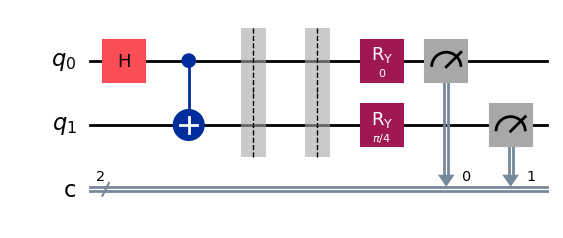

(x,y) = (0,1)


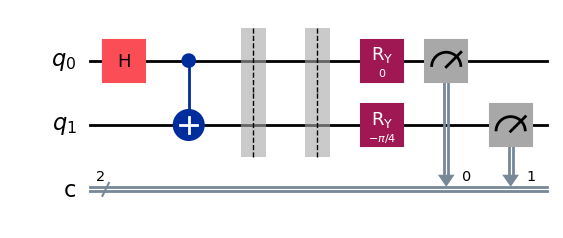

(x,y) = (1,0)


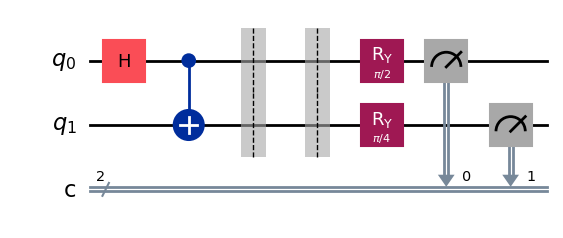

(x,y) = (1,1)


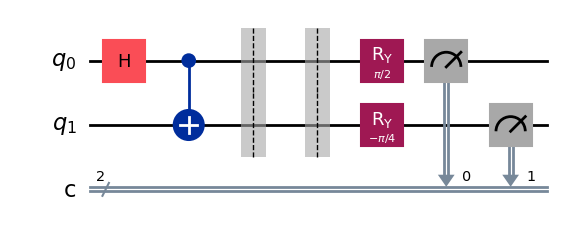

In [6]:
# Draw the four possible circuits
# Replace the ?

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw('mpl'))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw('mpl'))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw('mpl'))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw('mpl'))

Now we'll create a job using the Aer simulator that runs the circuit a single time for a given input pair 
(x,y).

In [7]:
sampler = Sampler()

def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Replace ?
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

Finally, we'll play the game 1,000 times and compute the fraction of them that the strategy wins.

In [8]:
# Replace ? 
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.856


We can also define a classical strategy and see how well it works. Feel free to change the code to try out different strategies!

In [9]:
def classical_strategy(x, y):
    """An optimal classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

Again let's play the game 1,000 times to see how well it works.

In [11]:
# Replace ?
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.749


Although there's randomness involved, the statistics are very unlikely to deviate too much after 1,000 runs. The quantum strategy wins about 85% of the time while a classical strategy can't win more than about 75% of the time.

# End of Notebook